In [1]:
import pymc3 as pm
import arviz as az
import theano as T
import theano.tensor as tt

import numpy as np
import matplotlib.pyplot as plt

<h1>Model definition</h1>

In [2]:
tau_m = 0.01
J = -1 * tau_m

def approx_q(nu_bar,alpha_0,tau_I):
    
    #tau_I = paras['tau_I']
    #alpha_0 = paras['alpha_0']
    #nu_bar = paras['nu_bar']
    
    nu_max = 1. / (2. * np.pi * np.sqrt( tau_I * tau_m ) )
    tau_q = 2. * (tau_I + tau_m)
    q_0 = alpha_0**2 / J**2.
        
    eps = tau_q * ( nu_bar**2 + q_0 ) / ( nu_bar + 2. * tau_q * (nu_bar**2 + q_0) )
    
    q = 1. / np.sqrt( 1. + 2 * tau_q * ( nu_bar + q_0 / nu_bar ) ) * \
        ( 1. + tau_q * ( nu_bar + q_0 / nu_bar ))**( 1. - eps ) * \
        nu_max**( 2. * eps ) * nu_bar**( 2. - 2. * eps )
    
    return q

def p_nu(NU,gamma,delta,nu_max):

    return gamma / ( nu_max * np.sqrt( -np.pi * np.log( NU / nu_max ) ) ) * \
        np.exp( - delta**2/2.) * ( NU / nu_max )**(gamma**2 - 1) * \
        np.cosh( gamma * delta * np.sqrt( -2 * np.log( NU / nu_max) ) )

def logP_nu(NU,gamma,delta,nu_max):
    
    return - tt.log( nu_max / gamma * np.sqrt( -np.pi * tt.log( NU / nu_max ) ) ) - delta**2 / 2 + \
        ( gamma**2 - 1 ) * tt.log( NU / nu_max ) + \
        tt.log( np.cosh( gamma * delta * np.sqrt( -2 * tt.log( NU / nu_max ) ) ) )

def logp_raw(NU,nu_bar,alpha_0,tau_I):
    
    # introduce checks for consistency, etc

    nu_max = 1. / (2. * np.pi * np.sqrt( tau_I * tau_m ) )

    q = approx_q(nu_bar,alpha_0,tau_I)

    sigma_I = np.sqrt(J**2 * nu_bar / ( 2 * tau_I ))
    sigma_V = np.sqrt(sigma_I**2 * tau_I / (tau_I + tau_m))
    alpha = np.sqrt(J**2 * q + alpha_0**2)

    selfcon_nu = nu_bar/nu_max * np.sqrt( alpha**2/sigma_V**2 + 1)
    selfcon_q = q/nu_max**2 * np.sqrt( 2*alpha**2/sigma_V**2 + 1)

    #if ((selfcon_nu < 1) and (selfcon_q < 1)):

    gamma = sigma_V / alpha

    I_0 = np.sqrt( -( alpha**2 + sigma_V**2 ) * np.log( ( nu_bar / nu_max )**2 * ( alpha**2/sigma_V**2 + 1 ) ) )
    delta = I_0 / alpha
    
    p_ = p_nu(NU,gamma,delta,nu_max)
    logP_ = logP_nu(NU,gamma,delta,nu_max)
    
    return p_, logP_

In [3]:
## create data for inference, or read from model
%cd ..
from create_measures import *
res = create_measures(L=1,S=[1,2],N=30,rerun=True)
print(res)

/home/wollex/Documents/Science/WolfGroup/DarkMatter/Programme


ModuleNotFoundError: No module named 'create_measures'

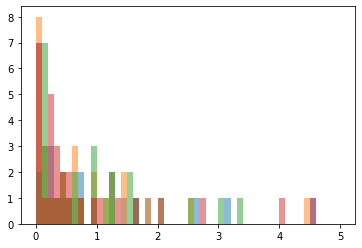

In [4]:
NU = np.squeeze(res['rates_T'])
#NU[NU==0] = 0.001
groups = np.array([len(rates)*[i] for i,rates in enumerate(NU.T)]).flatten()

n = NU.shape[1] # number of distinct tuples of (animals, hemispheres, layers)
obs_nu_bar = np.mean(NU,axis=0)   # should have 

for i in range(n):
    plt.hist(NU[:,i],np.linspace(0,5,51),alpha=0.5)
    
plt.show()

In [5]:
nnn = NU.flatten()
np.min(NU)

0.01

In [6]:
obs_nu_bar

masked_array(data=[1.26055556, 0.75938889, 0.92088889, 0.97316667],
             mask=False,
       fill_value=1e+20)

In [7]:
NU[groups]

masked_array(
  data=[[0.095     , 4.42833333, 0.95833333, 1.005     ],
        [0.095     , 4.42833333, 0.95833333, 1.005     ],
        [0.095     , 4.42833333, 0.95833333, 1.005     ],
        [0.095     , 4.42833333, 0.95833333, 1.005     ],
        [0.095     , 4.42833333, 0.95833333, 1.005     ],
        [0.095     , 4.42833333, 0.95833333, 1.005     ],
        [0.095     , 4.42833333, 0.95833333, 1.005     ],
        [0.095     , 4.42833333, 0.95833333, 1.005     ],
        [0.095     , 4.42833333, 0.95833333, 1.005     ],
        [0.095     , 4.42833333, 0.95833333, 1.005     ],
        [0.095     , 4.42833333, 0.95833333, 1.005     ],
        [0.095     , 4.42833333, 0.95833333, 1.005     ],
        [0.095     , 4.42833333, 0.95833333, 1.005     ],
        [0.095     , 4.42833333, 0.95833333, 1.005     ],
        [0.095     , 4.42833333, 0.95833333, 1.005     ],
        [0.095     , 4.42833333, 0.95833333, 1.005     ],
        [0.095     , 4.42833333, 0.95833333, 1.005     ],


RV : 


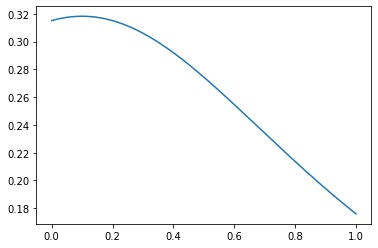

In [8]:
from scipy.stats import t 
x = np.linspace(0,1,1001);
numargs = t .numargs 

a = 1
b = 0.1
rv = t (a, b) 


print ("RV : \n", rv) 

plt.plot(x, rv.pdf(x))

#distribution = np.linspace(0, np.minimum(t.dist.b, 3)) 
#print("Distribution : \n", distribution) 

In [9]:
NU

masked_array(
  data=[[0.095     , 4.42833333, 0.95833333, 1.005     ],
        [0.26166667, 0.06833333, 0.02333333, 0.51      ],
        [0.15333333, 0.18      , 0.175     , 0.38666667],
        [4.515     , 0.61      , 1.52666667, 0.52666667],
        [2.65833333, 1.24666667, 0.68      , 0.295     ],
        [1.26333333, 0.11666667, 1.265     , 0.24      ],
        [0.07      , 0.65166667, 3.35166667, 2.04166667],
        [0.425     , 0.53333333, 0.98      , 0.44333333],
        [0.60333333, 0.46      , 0.12833333, 0.38833333],
        [0.54333333, 0.05166667, 0.06833333, 0.09333333],
        [0.93333333, 0.01      , 0.91833333, 0.01833333],
        [8.92833333, 1.11166667, 0.20166667, 0.095     ],
        [0.03      , 0.45166667, 0.77666667, 0.02333333],
        [0.14333333, 0.20833333, 1.56666667, 0.40166667],
        [1.6       , 0.62333333, 0.14      , 0.27      ],
        [0.05666667, 1.26      , 2.58666667, 0.25      ],
        [0.03      , 1.85      , 1.22166667, 0.22833333],


In [10]:
with pm.Model() as model:
    # replace normals with student-t distributions
    #mu_gamma = pm.HalfNormal('mu_gamma',sigma=1.);
    sigma_gamma = pm.HalfNormal('sigma_gamma',sigma=1.);
    
    gamma = pm.HalfNormal('gamma',sigma=sigma_gamma,shape=n);
    
    
    mu_nu_max = pm.Normal('mu_nu_max',mu=20.,sigma=5.);
    sigma_nu_max = pm.Normal('sigma_nu_max',mu=5.,sigma=2.);
    
    nu_max = pm.Normal('nu_max',mu=mu_nu_max,sigma=sigma_nu_max,shape=n);
    
    
    #mu_delta = pm.HalfNormal('mu_delta',sigma=5.);
    sigma_delta = pm.HalfNormal('sigma_delta',sigma=2.);
    
    #tau_I = pm.TruncatedNormal('tau_I',mu=mu_tau_I,sigma=sigma_tau_I,lower=0.,upper=0.1,shape=n);
    delta = pm.HalfNormal('delta',sigma=sigma_delta,shape=n);
    
    
    def likelihood(NU):
        # introduce checks for consistency, etc
        
        logP_ = logP_nu(NU,gamma,delta,nu_max)
        #logP_ = tt.switch(tt.lt(selfcon_nu,1), logP_, -10000.)
        #logP_ = tt.switch(tt.lt(selfcon_q,1), logP_, -10000.)
        logP_ = tt.switch(tt.isnan(logP_), -10000., logP_)
        
        tt.printing.Print('logP_')(tt.sum(logP_))

        #logP_ = tt.switch((selfcon_nu < 1) and (selfcon_q < 1), logP_.sum(), -10000.)
        return logP_.sum()
        
    
    logP = pm.DensityDist('logP',likelihood,observed={'NU':NU})
                   
    trace = pm.sample(
        init='adapt_diag',
        chains=4,draws=2000,tune=2000,
        target_accept=0.8,
        return_inferencedata=True)

logP_ __str__ = -194.98840088277487
logP_ __str__ = -194.98840088277487
logP_ __str__ = -194.98840088277487


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [delta, sigma_delta, nu_max, sigma_nu_max, mu_nu_max, gamma, sigma_gamma]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 44 seconds.
There were 982 divergences after tuning. Increase `target_accept` or reparameterize.
There were 777 divergences after tuning. Increase `target_accept` or reparameterize.
There were 939 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1019 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6974471248827977, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


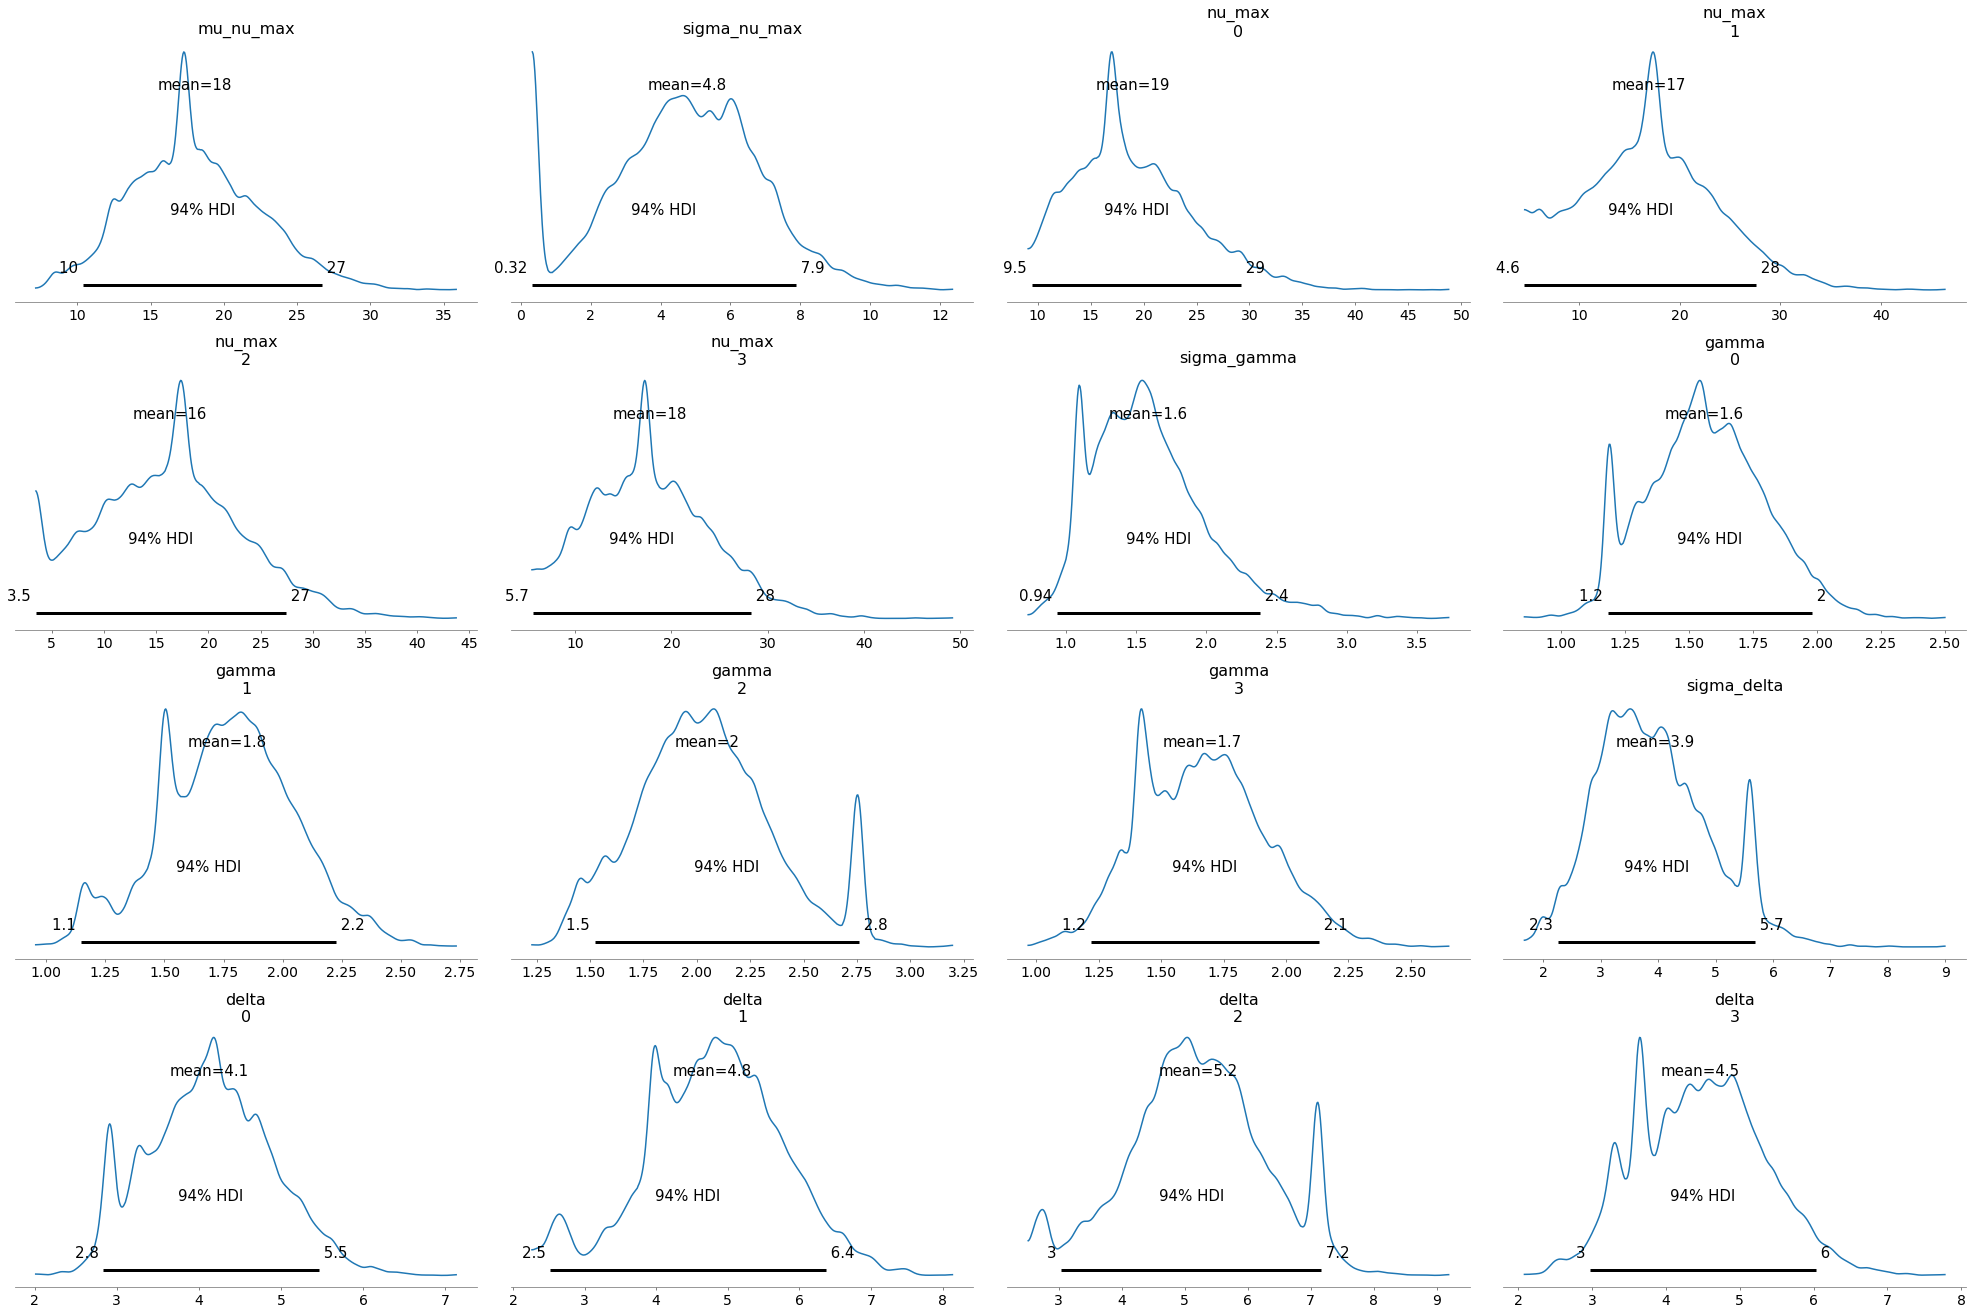

In [11]:
az.plot_posterior(trace)
plt.tight_layout()

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

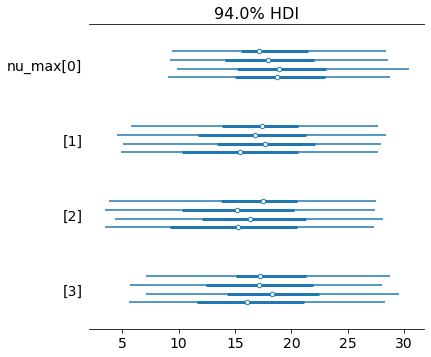

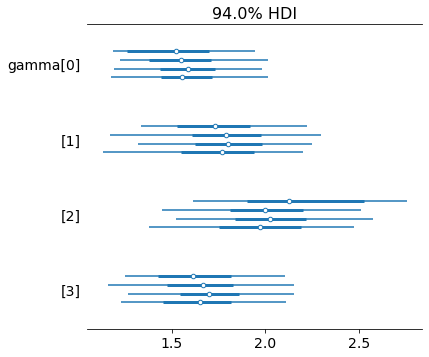

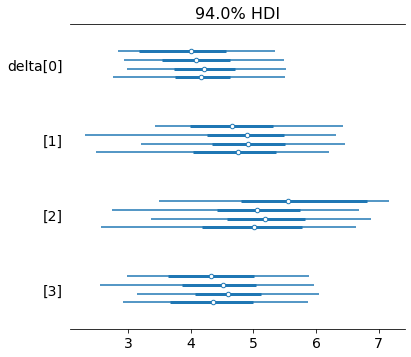

In [12]:
az.plot_forest(trace,var_names=['nu_max'])
az.plot_forest(trace,var_names=['gamma'])
az.plot_forest(trace,var_names=['delta'])

In [13]:
with model:
    display(az.summary(trace, round_to=2))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_nu_max,17.99,4.34,10.35,26.72,0.22,0.15,349.33,166.08,1.02
sigma_nu_max,4.76,2.09,0.32,7.87,0.26,0.18,67.35,19.55,1.04
nu_max[0],18.99,5.63,9.46,29.18,0.21,0.15,681.35,1227.59,1.01
nu_max[1],16.97,6.56,4.57,27.62,0.43,0.31,183.35,58.71,1.03
nu_max[2],16.30,6.87,3.47,27.41,0.43,0.31,167.00,37.78,1.03
nu_max[3],17.76,6.29,5.67,28.22,0.30,0.21,397.41,388.21,1.03
sigma_gamma,1.59,0.41,0.94,2.39,0.02,0.02,268.34,2493.89,1.01
gamma[0],1.56,0.23,1.18,1.98,0.02,0.01,171.42,53.52,1.02
gamma[1],1.77,0.28,1.15,2.23,0.03,0.02,121.82,33.00,1.02
gamma[2],2.05,0.33,1.52,2.76,0.04,0.03,63.51,35.46,1.05


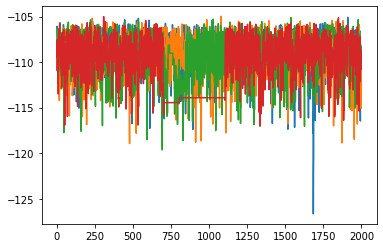

In [14]:
plt.plot(trace.log_likelihood['logP'][0,:,0])
plt.plot(trace.log_likelihood['logP'][1,:,0])
plt.plot(trace.log_likelihood['logP'][2,:,0])
plt.plot(trace.log_likelihood['logP'][3,:,0])

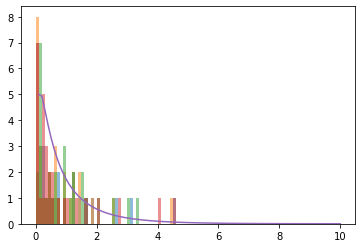

In [15]:
nu = np.linspace(0.1,10.,100)
p, log = logp_raw(nu,1.,0.02,0.005)

for i in range(n):
    plt.hist(NU[:,i],np.linspace(0,5,51),alpha=0.5)
    
plt.plot(nu,p*5)

plt.show()



<h1>Direct Hierarchical inference</h1>
<p>From here on, a variant of the model is set to infer parameters directly, including solving the selfoncistency equation during inference to obtain biological parameters</p>
<p>This is not possible with multiple populations, as the approximate solution to the selfconsistency equation has not (yet?) been found and a numerical solution might take to many resources</p>

In [16]:
with pm.Model() as model:
    # replace normals with student-t distributions
    mu_alpha_0 = pm.HalfNormal('mu_alpha_0',sigma=0.01);
    sigma_alpha_0 = pm.HalfNormal('sigma_alpha_0',sigma=0.02);
    
    alpha_0 = pm.HalfStudentT('alpha_0',sigma=mu_alpha_0,nu=sigma_alpha_0,shape=n);
    
    
    nu_bar = pm.Normal('nu_bar',obs_nu_bar,0.1,shape=n);
    
    
    mu_tau_I = pm.HalfNormal('mu_tau_I',sigma=0.01);
    sigma_tau_I = pm.HalfNormal('sigma_tau_I',sigma=0.01);
    
    #tau_I = pm.TruncatedNormal('tau_I',mu=mu_tau_I,sigma=sigma_tau_I,lower=0.,upper=0.1,shape=n);
    tau_I = pm.Normal('tau_I',mu=mu_tau_I,sigma=sigma_tau_I,shape=n);
    
    
    def likelihood(NU):
        # introduce checks for consistency, etc
        
        nu_max = 1. / (2. * np.pi * np.sqrt( tau_I * tau_m ) )
        
        q = approx_q(nu_bar,alpha_0,tau_I)
        
        sigma_I = np.sqrt(J**2 * nu_bar / ( 2 * tau_I ))
        sigma_V = np.sqrt(sigma_I**2 * tau_I / (tau_I + tau_m))
        alpha = np.sqrt(J**2 * q + alpha_0**2)
        
        selfcon_nu = nu_bar/nu_max * np.sqrt( alpha**2/sigma_V**2 + 1)
        selfcon_q = q/nu_max**2 * np.sqrt( 2*alpha**2/sigma_V**2 + 1)
        
        #if ((selfcon_nu < 1) and (selfcon_q < 1)):
        gamma = sigma_V / alpha

        I_0 = np.sqrt( -( alpha**2 + sigma_V**2 ) * np.log( ( nu_bar / nu_max )**2 * ( alpha**2/sigma_V**2 + 1 ) ) )
        delta = I_0 / alpha

        tt.printing.Print('nu_bar')(nu_bar)
        tt.printing.Print('mu_alpha_0')(mu_alpha_0)
        tt.printing.Print('sigma_alpha_0')(sigma_alpha_0)
        tt.printing.Print('alpha_0')(alpha_0)
        tt.printing.Print('mu_tau_I')(mu_tau_I)
        tt.printing.Print('sigma_tau_I')(sigma_tau_I)
        tt.printing.Print('tau_I')(tau_I)

        logP_ = logP_nu(NU,gamma,delta,nu_max)
        logP_ = tt.switch(tt.lt(selfcon_nu,1), logP_, -10000.)
        logP_ = tt.switch(tt.lt(selfcon_q,1), logP_, -10000.)
        logP_ = tt.switch(tt.isnan(logP_), -10000., logP_)
        
        tt.printing.Print('logP_')(tt.sum(logP_))

        #logP_ = tt.switch((selfcon_nu < 1) and (selfcon_q < 1), logP_.sum(), -10000.)
        return logP_.sum()
        
    
    logP = pm.DensityDist('logP',likelihood,observed={'NU':NU})
                   
    trace = pm.sample(
        init='adapt_diag',
        chains=4,draws=5000,tune=2000,
        target_accept=0.8,
        return_inferencedata=True)

nu_bar __str__ = [1.26055556 0.75938889 0.92088889 0.97316667]
mu_alpha_0 __str__ = 0.007978845608028655
sigma_alpha_0 __str__ = 0.01595769121605731
alpha_0 __str__ = [0.00797885 0.00797885 0.00797885 0.00797885]
mu_tau_I __str__ = 0.007978845608028655
sigma_tau_I __str__ = 0.007978845608028655
tau_I __str__ = [0.00797885 0.00797885 0.00797885 0.00797885]
logP_ __str__ = -239.3535689809528
nu_bar __str__ = [1.26055556 0.75938889 0.92088889 0.97316667]
mu_alpha_0 __str__ = 0.007978845608028655
sigma_alpha_0 __str__ = 0.01595769121605731
alpha_0 __str__ = [0.00797885 0.00797885 0.00797885 0.00797885]
mu_tau_I __str__ = 0.007978845608028655
sigma_tau_I __str__ = 0.007978845608028655
tau_I __str__ = [0.00797885 0.00797885 0.00797885 0.00797885]
logP_ __str__ = -239.3535689809528
nu_bar __str__ = [1.26055556 0.75938889 0.92088889 0.97316667]
mu_alpha_0 __str__ = 0.007978845608028655
sigma_alpha_0 __str__ = 0.01595769121605731
alpha_0 __str__ = [0.00797885 0.00797885 0.00797885 0.00797885]
m

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [tau_I, sigma_tau_I, mu_tau_I, nu_bar, alpha_0, sigma_alpha_0, mu_alpha_0]


Sampling 4 chains for 2_000 tune and 5_000 draw iterations (8_000 + 20_000 draws total) took 56 seconds.
There were 3341 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6409849659601753, but should be close to 0.8. Try to increase the number of tuning steps.
There were 3164 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3187 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3015 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7115352572609367, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


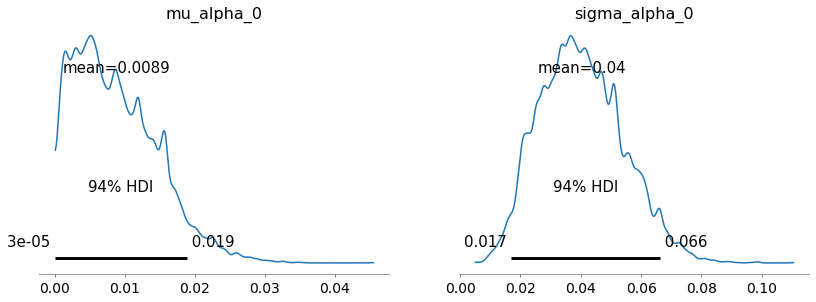

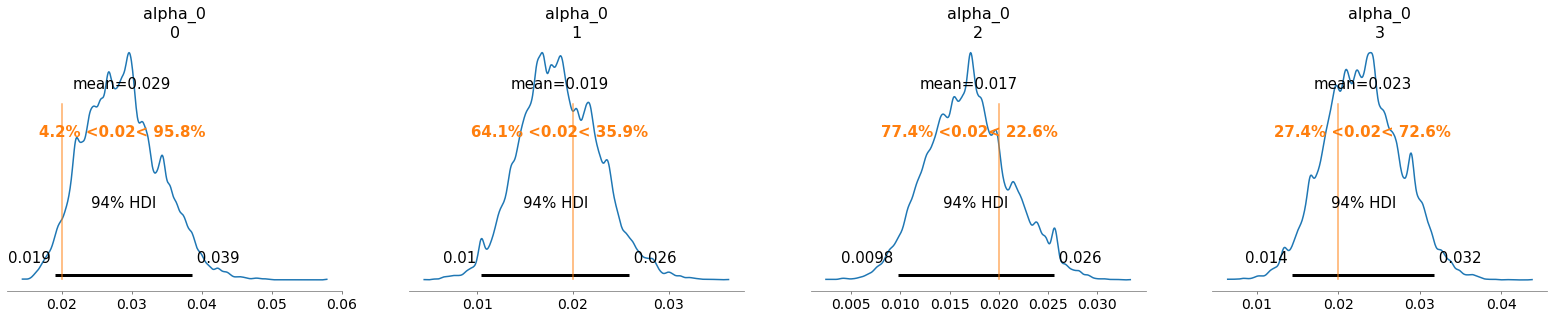

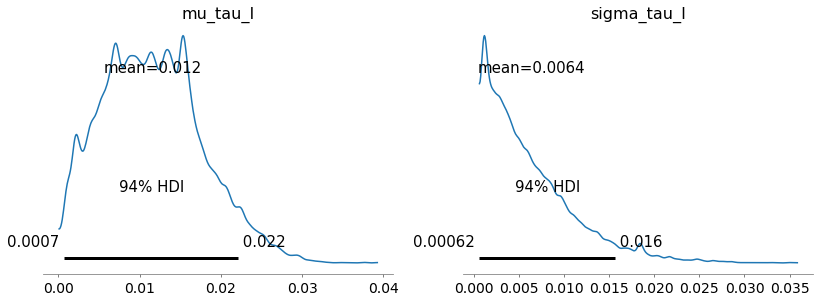

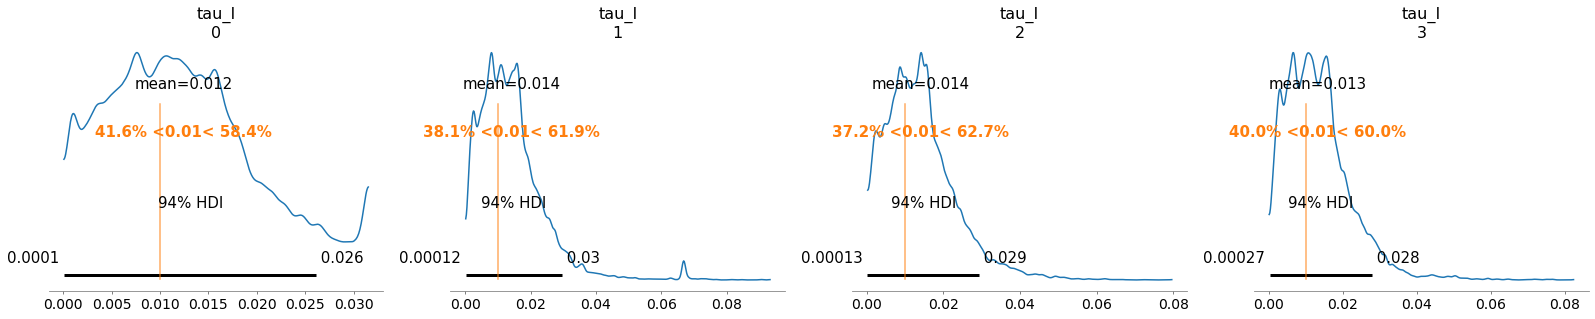

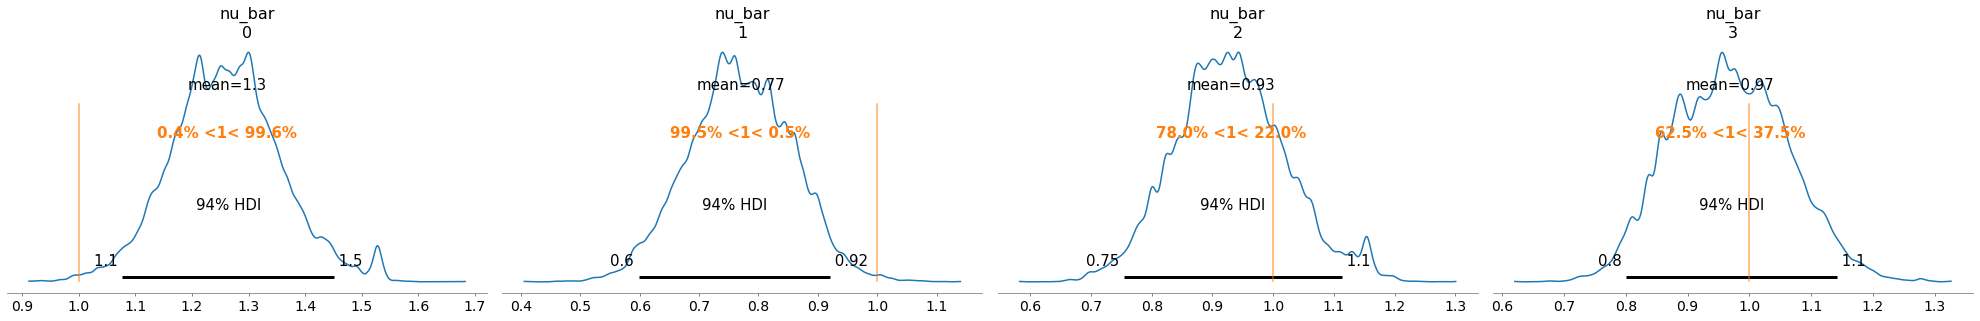

In [17]:
az.plot_posterior(trace,var_names=['_alpha_0$'], filter_vars="regex")
az.plot_posterior(trace,var_names=['^alpha_0'], filter_vars="regex", ref_val=0.02)
az.plot_posterior(trace,var_names=['_tau_I$'], filter_vars="regex")
az.plot_posterior(trace,var_names=['^tau_I'], filter_vars="regex", ref_val=0.01)
az.plot_posterior(trace,var_names=['nu_bar'], ref_val=1)
plt.tight_layout()



(0.0, 0.05)

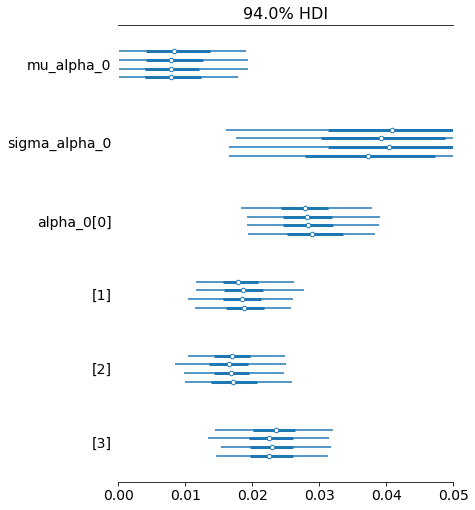

In [18]:
az.plot_forest(trace,var_names=['alpha_0$'], filter_vars='regex')
plt.xlim([0,0.05])

In [20]:
nu = np.linspace(0.,2.,101)
plt.plot(nu,approx_q({'tau_I': 0.005, 'alpha_0': 0.04, 'nu_bar': nu}))
plt.plot(nu,nu**2,'r--')
plt.show()

TypeError: approx_q() missing 2 required positional arguments: 'alpha_0' and 'tau_I'